# #1

# Análisis de Series Temporales con K-Medoids y DTW

## Decisión metodológica clave: No interpolación de datos

**Por qué no interpolamos:**
- Preservamos los datos originales sin alteraciones artificiales
- Evitamos introducir sesgos en los patrones de consumo reales
- Aceptamos la naturaleza irregular de los datos de consumo eléctrico:
  - Hogares con distintos períodos de medición
  - Dispositivos con diferentes frecuencias de registro

## Elección de K-Medoids (PAM)

**Ventajas sobre otros algoritmos:**

| Característica | K-Medoids | K-Means |
|---------------|-----------|---------|
| Robustez a outliers | Alta | Media |
| Uso con matrices de distancia | Sí | No |
| Centroides | Puntos reales (medoides) | Medias artificiales |
| Coste computacional | Mayor | Menor |

**Razones específicas para nuestro caso:**
1. **Interpretabilidad**: Cada centroide es una observación real (no un punto artificial)
2. **Estabilidad**: Menos sensible a outliers que K-Means
3. **Compatibilidad**: Funciona perfectamente con matrices de distancia precomputadas

## Selección de DTW (Dynamic Time Warping)

### Por qué `cdist_dtw` es ideal

**Problemas que resuelve:**
- Series de diferente longitud
- Desfases temporales en patrones similares
- Variaciones no lineales en el tiempo

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from joblib import dump

In [26]:
df = pd.read_csv("../../../data/vertical_preprocessed_data.csv", sep=";")

import warnings
warnings.filterwarnings("ignore")

## Definicion de las clases

Primero definimos las clases que van a formar nuestro pipeline, son 3 etapas: Preprocesamiento, seleccion del numero de cluster,ejecucion del clustering.

In [ ]:
class ClusterSelection:
    def __init__(self, max_clusters=10):
        self.max_clusters = max_clusters

    def select_optimal_clusters(self, X):
        X_array = [np.asarray(series) for series in X]
        
        dist_matrix = cdist_dtw(X_array)
        
        silhouette_scores = []
        for k in range(2, self.max_clusters + 1):
            try:
                model = KMedoids(n_clusters=k, metric='precomputed', init='k-medoids++', random_state=42)
                labels = model.fit_predict(dist_matrix)
                
                if len(np.unique(labels)) == 1:
                    raise ValueError("Todos los puntos asignados a un solo cluster")
                
                score = silhouette_score(dist_matrix, labels, metric='precomputed')
                silhouette_scores.append(score)
            except Exception as e:
                print(f"⚠️ Advertencia con k={k}: {str(e)}")
                silhouette_scores.append(-1)
                continue

        if all(score == -1 for score in silhouette_scores):
            raise RuntimeError("No se pudo calcular ningún score de Silhouette válido")
        
        best_k = np.argmax(silhouette_scores) + 2
        print(f"🔍 Mejor número de clusters (Silhouette con DTW): {best_k}")
        print(f"Detalle de scores: {list(zip(range(2, self.max_clusters+1), silhouette_scores))}")

        plt.figure(figsize=(10, 6))
        plt.plot(range(2, self.max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
        plt.title("Evaluación de Clusters con DTW\n(Silhouette Score para diferentes K)")
        plt.xlabel("Número de Clusters (K)")
        plt.ylabel("Silhouette Score")
        plt.xticks(range(2, self.max_clusters + 1))
        plt.grid(True)
        plt.show()

        return best_k

## Min-Max Scaling en el preprocesamiento

- Hemos seleccionado **TimeSeriesScalerMinMax** por estas razones clave:

| Escalado | Ventaja para DTW | Ventaja para DTW |
|---------------|-----------|---------|
| Min-Max | Mantiene la forma de onda | Evita que series con mayor magnitud dominen el clustering |
| Standard | Genera valores negativos | Distorsiona la interpretación de consumos (kWh nunca son negativos) |

- Consecuencia para DTW:
	- StandardScaler podría enmascarar patrones al centrar en cero
	- Min-Max mantiene la proporcionalidad temporal

- Al normalizar con Min-Max:

El clustering identifica patrones similares aunque difieran en escala absoluta. Dos viviendas con patrón matutino similar y diferentes niveles de consumo serán agrupadas correctamente.

Esta normalización es especialmente crítica cuando comparamos consumos de viviendas con diferentes potencias contratadas o hábitos de consumo muy dispares


In [28]:
class TimeSeriesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.scaler = TimeSeriesScalerMinMax() if normalize else None
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_sorted = X.sort_values(by=['cups', 'fecha', 'hora'])
        series_list = []
        self.cups_list_ = []
        
        for cups, group in X_sorted.groupby('cups'):
            series = group['consumo_kWh'].values
            series_list.append(series)
            self.cups_list_.append(cups)
            
        if self.normalize:
            series_normalized = []
            for s in series_list:
                s_reshaped = np.reshape(s, (-1, 1))
                normalized = self.scaler.fit_transform(s_reshaped)
                series_normalized.append(normalized.flatten())
            return series_normalized
        else:
            return series_list

In [29]:
class TimeSeriesClustering(BaseEstimator):
    def __init__(self, n_clusters=None):
        self.n_clusters = n_clusters
        self.cluster_selector = ClusterSelection()

    def fit(self, X, y=None):
        self.dist_matrix_ = cdist_dtw(X)

        if self.n_clusters is None:
            self.n_clusters = self.cluster_selector.select_optimal_clusters(X)

        self.model = KMedoids(n_clusters=self.n_clusters, metric='precomputed', random_state=42)
        self.labels_ = self.model.fit_predict(self.dist_matrix_)
        return self

    def transform(self, X):
        return self.labels_

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

🔎 Mejor número de clusters (Silhouette con DTW): 2


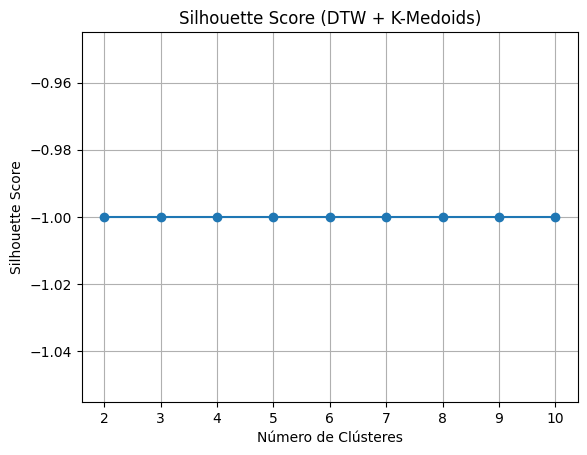

In [34]:
preprocessor = TimeSeriesPreprocessor(normalize=True)

# Aplicar preprocesamiento al DataFrame
X_processed = preprocessor.fit_transform(df)

# Seleccionar el número óptimo de clusters
my_cluster = ClusterSelection(max_clusters=10)
n_cluster = my_cluster.select_optimal_clusters(X_processed)

🔎 Mejor número de clusters (Silhouette con DTW): 2


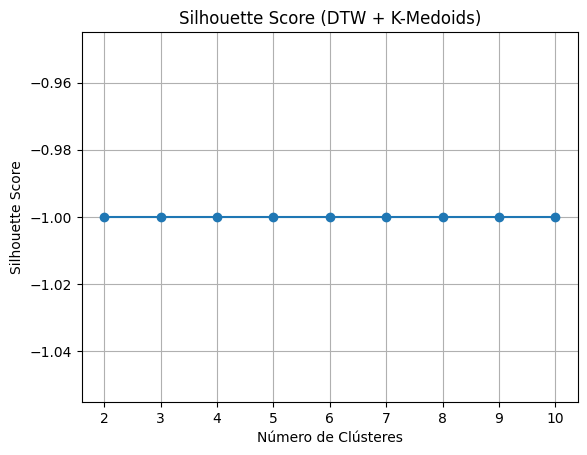

['kmedoids_dtw_minmax_normalized.joblib']

In [30]:
pipeline = Pipeline([
    ('preprocessor', TimeSeriesPreprocessor()),
    ('clustering', TimeSeriesClustering(n_clusters=None)),
])

# === Ejecutar el pipeline ===
pipeline.fit_transform(df)

modelo_kmedoids = pipeline.named_steps['clustering'].model
dump(modelo_kmedoids, 'kmedoids_dtw_minmax_normalized.joblib')